<a href="https://colab.research.google.com/github/N-HAFSA/MBD-DataAnalytics-EyesDeseses/blob/main/DataAnalytics_EyesDesieses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the data

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
! pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
! ls

adc.json  sample_data


In [ ]:
file_id = "1QOrBAUsgpxFnjABtooHfI_nI8T_am7mo"

In [ ]:
download = drive.CreateFile({'id': file_id})
download.GetContentFile("data.zip")

In [ ]:
! ls

adc.json  data.zip  sample_data


In [ ]:
! unzip data.zip -d data

Archive:  data.zip
   creating: data/1/
   creating: data/1/test/
   creating: data/1/test/0/
  inflating: data/1/test/0/10411_right.jpeg  
   creating: data/__MACOSX/
   creating: data/__MACOSX/1/
   creating: data/__MACOSX/1/test/
   creating: data/__MACOSX/1/test/0/
  inflating: data/__MACOSX/1/test/0/._10411_right.jpeg  
  inflating: data/1/test/0/10437_right.jpeg  
  inflating: data/__MACOSX/1/test/0/._10437_right.jpeg  
  inflating: data/1/test/0/10423_left.jpeg  
  inflating: data/__MACOSX/1/test/0/._10423_left.jpeg  
  inflating: data/1/test/0/10449_right.jpeg  
  inflating: data/__MACOSX/1/test/0/._10449_right.jpeg  
  inflating: data/1/test/0/10437_left.jpeg  
  inflating: data/__MACOSX/1/test/0/._10437_left.jpeg  
  inflating: data/1/test/0/10419_right.jpeg  
  inflating: data/__MACOSX/1/test/0/._10419_right.jpeg  
  inflating: data/1/test/0/10409_left.jpeg  
  inflating: data/__MACOSX/1/test/0/._10409_left.jpeg  
  inflating: data/1/test/0/1041_left.jpeg  
  inflating: data

In [ ]:
! ls ./data/1/

test  train


# Let's try to mont the Google drive with Colab (Let's ignore this part)






In [ ]:
# Load the Drive helper and mount
#from google.colab import drive
# This will prompt for authorization.
#drive.mount('/content/drive')

## Check the directory path

In [ ]:
! ls drive/My\ Drive/workshop_13_dec

ls: cannot access 'drive/My Drive/workshop_13_dec': No such file or directory


## Import the libraries

In [ ]:
import numpy as np
import tensorflow as tf
import math

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Input, BatchNormalization
from keras import regularizers
from keras.initializers import he_uniform
from keras.optimizers import Adam
import matplotlib.pyplot as plt
 

from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
%matplotlib inline

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 250
image_gen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

train_gen = image_gen.flow_from_directory(batch_size =BATCH_SIZE,
                                          directory = "./data/1/train/",
                                          target_size =(IMG_SIZE,IMG_SIZE),
                                          shuffle =True,
                                          class_mode = "binary")


Found 800 images belonging to 2 classes.


In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory="./data/1/test/",
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 class_mode='binary')

Found 80 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

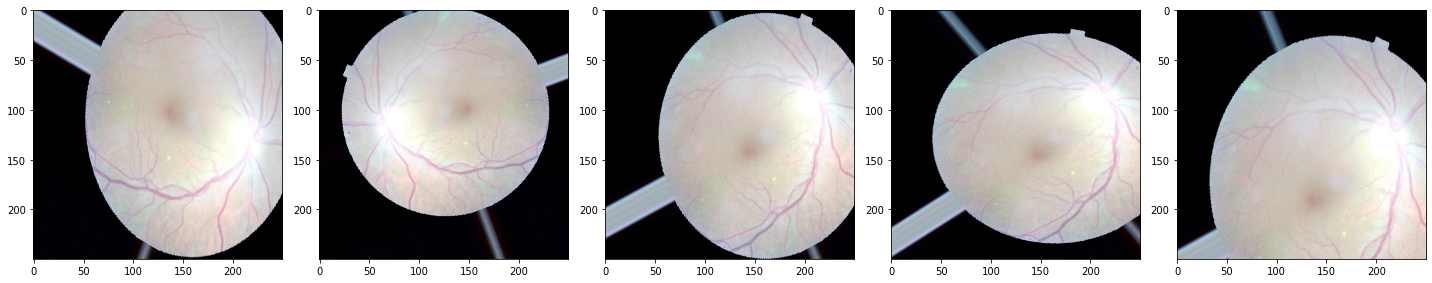

In [ ]:
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2,activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [ ]:
#comile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit(
    train_gen,
    validation_data = val_data_gen,
    epochs=EPOCHS)

Epoch 1/15
25/25 [==============================] - 126s 5s/step - loss: 0.8571 - accuracy: 0.4645 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
25/25 [==============================] - 123s 5s/step - loss: 0.6936 - accuracy: 0.4759 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
25/25 [==============================] - 123s 5s/step - loss: 0.6933 - accuracy: 0.4718 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
25/25 [==============================] - 127s 5s/step - loss: 0.6931 - accuracy: 0.5209 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/15
25/25 [==============================] - 123s 5s/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/15
25/25 [==============================] - 123s 5s/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/15
25/25 [==============================] - 123s 5s/step - loss: 0.6933 - accuracy: 0.4746 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/15
25

In [ ]:
def visualizeResults(history,num_epoches) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epoches)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

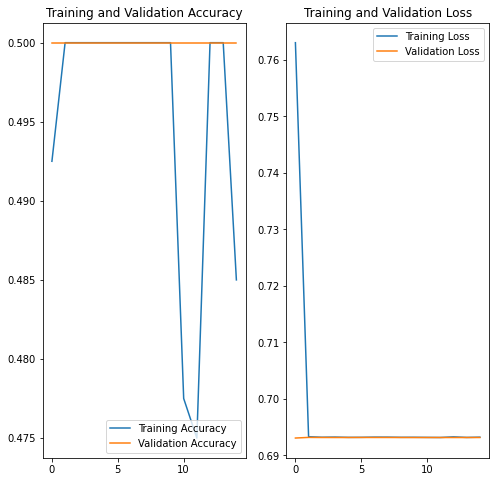

In [ ]:
visualizeResults(history,EPOCHS) 

# Seconde ***Model***

# Now we try with a pretrained Model
lets see if we can get the accuracy better from the previous model

In [ ]:
import tensorflow_hub as hub

In [ ]:
URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
IMG_SIZE = 299
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_SIZE,IMG_SIZE,3))
feature_extractor.trainable = False

In [ ]:
model_inception = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2,activation="softmax")                                 
])

In [ ]:
model_inception.compile(optimizer =Adam(lr=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=["accuracy"])

In [ ]:
EPOCHS = 10
history = model_inception.fit(train_gen,epochs=EPOCHS,validation_data=val_data_gen)

Epoch 1/10
25/25 [==============================] - 142s 5s/step - loss: 0.7896 - accuracy: 0.5235 - val_loss: 0.6881 - val_accuracy: 0.6000
Epoch 2/10
25/25 [==============================] - 136s 5s/step - loss: 0.6881 - accuracy: 0.5501 - val_loss: 0.6847 - val_accuracy: 0.5250
Epoch 3/10
25/25 [==============================] - 136s 5s/step - loss: 0.6818 - accuracy: 0.5647 - val_loss: 0.6685 - val_accuracy: 0.5875
Epoch 4/10
25/25 [==============================] - 139s 6s/step - loss: 0.6902 - accuracy: 0.5314 - val_loss: 0.6827 - val_accuracy: 0.5250
Epoch 5/10
25/25 [==============================] - 136s 5s/step - loss: 0.6703 - accuracy: 0.5679 - val_loss: 0.6664 - val_accuracy: 0.6250
Epoch 6/10
25/25 [==============================] - 136s 5s/step - loss: 0.6668 - accuracy: 0.5792 - val_loss: 0.6559 - val_accuracy: 0.6250
Epoch 7/10
25/25 [==============================] - 136s 5s/step - loss: 0.6537 - accuracy: 0.6205 - val_loss: 0.6478 - val_accuracy: 0.5750
Epoch 8/10
25

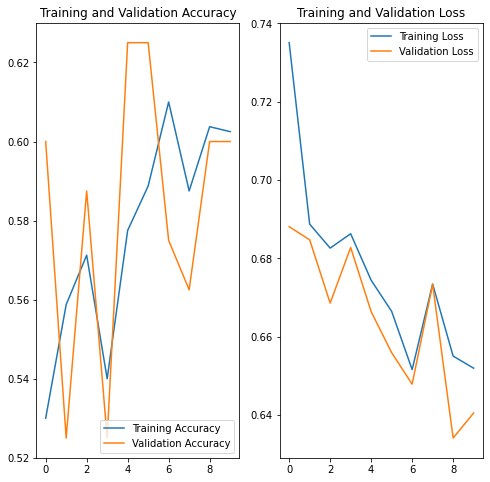

In [ ]:
visualizeResults(history,EPOCHS)